Pipeline

1. 모든 store, item에 대한 정보를 cluster별로 확보한다(이 때 3개월 단위로 합산)
2. y값에 따라 데이터를 다르게 구성한다 
3. 모델을 apply하여 예측값 산출

### 하나의 상점에 대한 예측 모델

In [169]:
import json

with open('../data/preprocessed/3_month_retail.json', 'r') as f:
    data = json.load(f)

In [170]:
data.keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157'

In [171]:
len(data['1']['Shrimp'])
#3개월로 끊었기에 N = 29

29

In [172]:
with open('../data/preprocessed/cluster_store.json','r') as f:
    cluster = json.load(f)

In [173]:
cluster

{'0': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  128,
  137,
  138,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  17

In [174]:
cluster['1']

[492,
 497,
 499,
 508,
 510,
 514,
 515,
 521,
 523,
 526,
 527,
 529,
 530,
 531,
 534,
 535,
 537,
 538,
 541,
 542,
 543,
 544,
 548,
 549,
 552,
 553,
 560,
 561,
 564,
 565,
 568,
 572,
 575,
 578,
 586,
 590,
 596,
 597,
 599,
 600,
 602,
 606,
 609,
 610,
 611,
 613,
 614,
 616,
 617,
 623,
 624,
 626,
 627,
 628,
 631,
 632,
 634,
 636,
 637,
 641,
 642]

In [175]:
# 1번 클러스터의 첫 번째 상점인 492 상점의 품목들을 예측하는 모델을 해보자
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

In [176]:
# 1번 cluster 내부의 상점들의
# torch.cat((x, y, z), 0)
# 1과 2 상점 두개만 우선 가져와서 해보자
t1 = torch.tensor(list(data['1'].values()))
t2 = torch.tensor(list(data['2'].values()))
t3 = torch.cat((t1, t2),0)
# X로 설정할때는 하나 빼야하니까 y가 shift되기 때문
t4 = t3[:,:-1]

print(t3.size())
print(t4.size())

torch.Size([36, 29])
torch.Size([36, 28])


In [177]:
k = torch.tensor([])
k2 = torch.tensor([2,3])
k3 = torch.cat((k,k2),0)
print(k3)

tensor([2., 3.])


In [178]:
# cluster 번호를 지정해주면, 거기 안의 데이터를 X로 return 해주는 함수를 만들자
def cluster_dataset(cluster_num):
    data_tensor = torch.tensor([])
    for store_id in cluster[cluster_num]:
        sub_tensor = torch.tensor(list(data[str(store_id)].values()))
        data_tensor = torch.cat((data_tensor,sub_tensor),0)
    return data_tensor[:,:-1].t()
    

In [183]:
X = cluster_dataset('3')

In [184]:
X.size()

torch.Size([28, 2610])

In [154]:
t1 = torch.tensor(list(data['492'].values()))

In [155]:
t2 = torch.tensor(list(data['492'].values()))

In [158]:
torch.cat((t1, t2),0).size()

torch.Size([36, 29])

In [125]:
X = cluster_dataset('1')

In [126]:
X.size()

torch.Size([28, 1098])

In [44]:
X = torch.FloatTensor(X)

In [45]:
# making y
# y는 492 값을 하나 shift(-1) 시킨 것임. 
y = torch.tensor(list(data['492'].values()))[-1][1:]

In [141]:
y = torch.tensor(data[str('492')]['Brush'][:]).float()

In [163]:
torch.tensor([0., 0., 0., 0., 0., 0.]).size()

torch.Size([6])

In [165]:
torch.rand(642 * 17).size()

torch.Size([10914])

In [46]:
data['492'].keys()

dict_keys(['Bracket', 'Brush', 'Steak', 'Shrimp', 'Power Cord', 'Phone Charger', 'Paint', 'Noodles', 'Nails', 'Mouse', 'Milk', 'King Crab', 'Keyboard', 'Glue', 'Eggs', 'Ear Buds', 'Cereal', 'Tape'])

In [47]:
data['492']['Bracket']

[0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [48]:
list(data['492'].values())[-1][1:]

[1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [49]:
y = y.float()

In [75]:
X_train = X[:26]
y_train = y[:26]

X_test = X[26:]
y_test = y[26:]

dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=3, shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [137]:
X[27:].size()

torch.Size([1, 1098])

In [129]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)

In [76]:
class DSModel(nn.Module):
    def __init__(self):
        super(DSModel, self).__init__()
        # self.layer1 = torch.nn.Sequential(
        #     torch.nn.Conv1d(1098, 256, kernel_size=2),
        #     torch.nn.ReLU(),
        #     torch.nn.MaxPool1d(kernel_size=2, stride=1)
        # )
        self.fc1 = nn.Linear(1098,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,8)
        self.fc4 = nn.Linear(8,1)
    
    def forward(self, x):
        # x = F.relu(self.layer1(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x


In [77]:
model = DSModel()
criterion = nn.MSELoss()

In [78]:
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-7)

In [79]:
DSModel()

DSModel(
  (fc1): Linear(in_features=1098, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)

In [80]:
loss_ = []
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader,0):
        inputs, value = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, value)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_.append(running_loss)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [81]:
import matplotlib.pyplot as plt

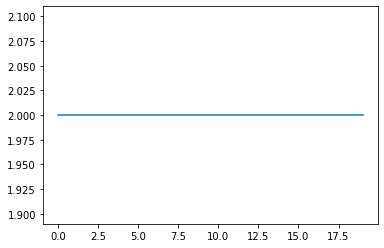

In [82]:
plt.plot(loss_)
plt.show()

In [83]:
def evaluation(dataloader):
    predictions = torch.tensor([], dtype=torch.float)
    actual = torch.tensor([], dtype=torch.float)

    with torch.no_grad():
        model.eval()

        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)
            predictions = torch.cat((predictions, outputs),0)
            actual = torch.cat((actual, values),0)
        predictions = predictions.numpy()
        actual = actual.numpy()
        rmse = np.sqrt(mean_squared_error(predictions, actual))
    return rmse, predictions, actual

In [61]:
train_rmse, pre1, ac1 = evaluation(train_dataloader)
test_rmse, pre2, ac2 = evaluation(test_dataloader)

print(f'train rmse:{train_rmse}')
print(f'test rmse:{test_rmse}')

train rmse:0.4803844690322876
test rmse:0.0


In [62]:
pre2

array([[0.],
       [0.]], dtype=float32)

In [63]:
ac2

array([0., 0.], dtype=float32)

In [23]:
X_test

NameError: name 'X_test' is not defined

In [65]:
X_test[0]

tensor([0., 2., 0.,  ..., 1., 0., 0.])

In [86]:
model(X_test[0])

tensor([0.], grad_fn=<ReluBackward0>)

In [98]:
torch.round(model(X_test[0])).tolist()

[0.0]

In [130]:
torch.tensor([])

tensor([])

In [133]:
torch.rand((1,1))

tensor([[0.9142]])